In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    %config Completer.use_jedi = False
except:
    pass

import numpy as np
from astropy.table import Table, join
from astropy.io import fits
import time
import matplotlib.pyplot as plt
from scipy import signal, optimize
import glob

In [2]:
dr60 = Table.read('../observations/dr6.0_220701.fits')
dr60.sort('sobject_id')
uni, uni_ind = np.unique(dr60['sobject_id'],return_index=True)
if len(dr60['sobject_id']) != len(uni):
    dr60 = dr60[uni_ind]
    dr60.write('../observations/dr6.0_220701.fits',overwrite=True)

In [3]:
try:
    extra_info = Table.read('../observations/dr6.0_220701_additional_wavelength_info.fits')
except:
    extra_info = Table()
    extra_info['sobject_id'] = dr60['sobject_id']
    extra_info['date'] = np.array([str(x)[:6] for x in dr60['sobject_id']],dtype=str)
    extra_info['SLITMASK'] = np.zeros(len(dr60['sobject_id']),dtype=int); extra_info['SLITMASK'][:] = 2

    for key in ['CRVAL1', 'CDELT1', 'RVCOM', 'RV']:
        for ccd in [1,2,3,4]:
            extra_info[key+'_ccd'+str(ccd)] = np.zeros(len(dr60['sobject_id']),dtype=np.float32); extra_info[key+'_ccd'+str(ccd)][:] = np.NaN
            
    start_time = time.time()

    for index, sobject_id in enumerate(dr60['sobject_id']):

        if index%1000 == 1:
            time_now = time.time()
            print(index,'/',len(dr60['sobject_id']))
            print('took ',time_now-start_time,' s, expected finish: ', (time_now-start_time)/index * (len(dr60['sobject_id']) - index))

        for ccd in [1,2,3,4]:
            try:
                fits_file = fits.open('../observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')

                if ccd == 1:
                    if fits_file[0].header['SLITMASK'] == 'OUT':
                        extra_info['SLITMASK'][index] = 0
                    elif fits_file[0].header['SLITMASK'] == 'IN':
                        extra_info['SLITMASK'][index] = 1
                    else:
                        extra_info['SLITMASK'][index] = 3

                for key in ['CRVAL1', 'CDELT1', 'RVCOM', 'RV']:
                    try:
                        extra_info[key+'_ccd'+str(ccd)][index] = fits_file[0].header[key]
                    except:
                        pass

                fits_file.close()
            except:
                pass
    #             print('Failed for '+str(sobject_id)+' at index '+str(index),' for ',key)
    
    
    # Get rid of precision errors in data formats
    extra_info['rvcom_d3'] = np.round(dr60['rv_com'],decimals=2)
    extra_info['RVCOM_d3_ccd1'] = np.round(extra_info['RVCOM_ccd1'],decimals=2)
    extra_info['RVCOM_d3_ccd2'] = np.round(extra_info['RVCOM_ccd2'],decimals=2)
    extra_info['RVCOM_d3_ccd3'] = np.round(extra_info['RVCOM_ccd3'],decimals=2)
    extra_info['RVCOM_d3_ccd4'] = np.round(extra_info['RVCOM_ccd4'],decimals=2)
    
    extra_info['RVCOM_same_in_tables'] = extra_info['rvcom_d3'] == extra_info['RVCOM_d3_ccd1']
    extra_info['RVCOM_d3_ccd_same'] = np.all([extra_info['RVCOM_d3_ccd1'] == extra_info['RVCOM_d3_ccd2'],extra_info['RVCOM_d3_ccd1'] == extra_info['RVCOM_d3_ccd3'],extra_info['RVCOM_d3_ccd1'] == extra_info['RVCOM_d3_ccd4']],axis=0)
    
    extra_info.write('../observations/dr6.0_220701_additional_wavelength_info.fits',overwrite=True)
    

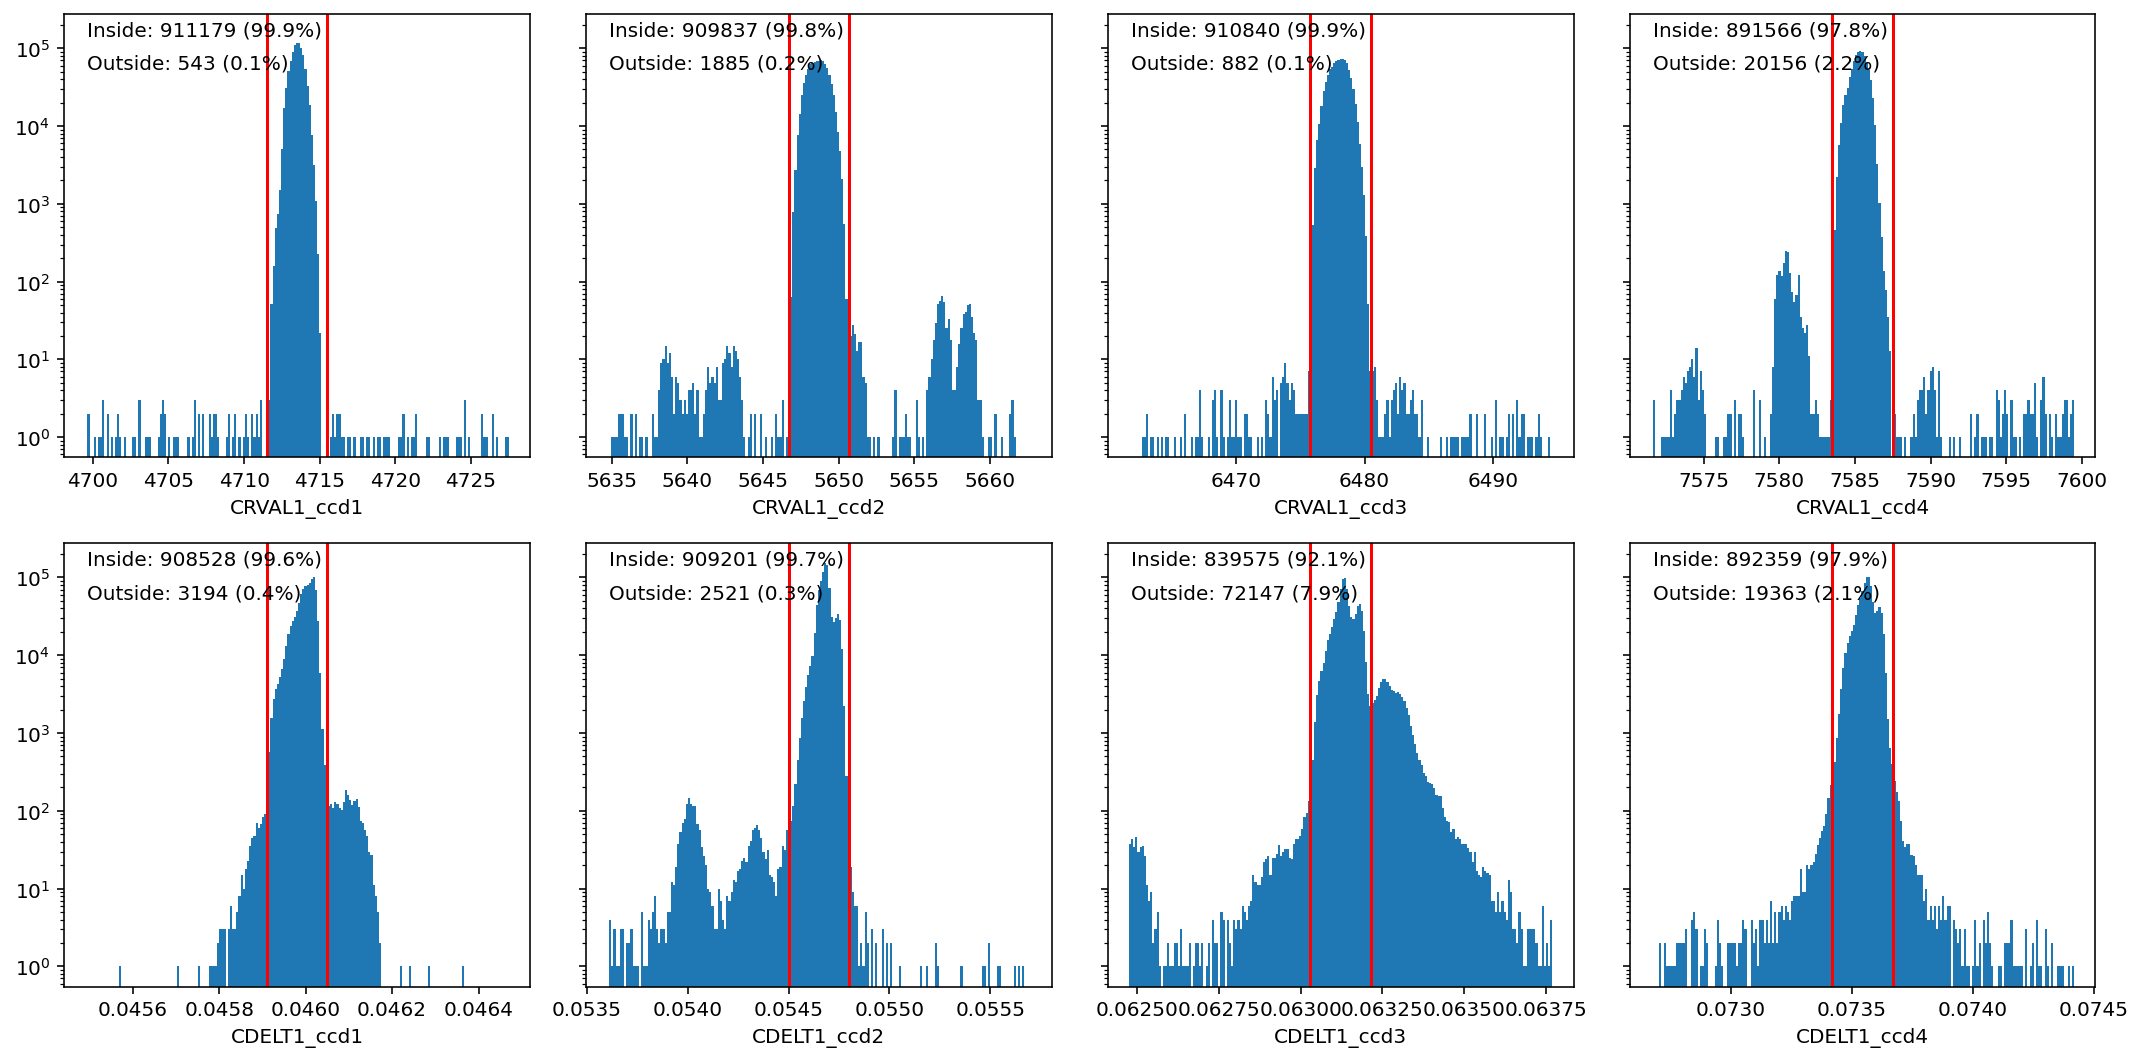

In [5]:
ranges = dict()

f, gs = plt.subplots(2,4,figsize=(15,7.5),sharey=True)

for ccd in [1,2,3,4]:
    for cindex, key in enumerate(['CRVAL1','CDELT1']):
        
        ax = gs[cindex,ccd-1]
        
        ranges[key+'_ccd'+str(ccd)+'_p1'], ranges[key+'_ccd'+str(ccd)+'_p99'] = np.nanpercentile(extra_info[key+'_ccd'+str(ccd)],q=[0.1,99.9])
        if key == 'CRVAL1':
            if ccd == 1:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 4711.5
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 4715.5
            if ccd == 2:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 5646.7
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 5650.7
            if ccd == 3:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 6475.8
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 6480.5
            if ccd == 4:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 7583.5
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 7587.5
        if key == 'CDELT1':
            if ccd == 1:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 0.04591
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 0.04605
            if ccd == 2:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 0.0545
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 0.0548
            if ccd == 3:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 0.06303
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 0.063215
            if ccd == 4:
                ranges[key+'_ccd'+str(ccd)+'_p1'] = 0.07342
                ranges[key+'_ccd'+str(ccd)+'_p99'] = 0.07367
                
        left = ranges[key+'_ccd'+str(ccd)+'_p1'] - 3*(ranges[key+'_ccd'+str(ccd)+'_p99'] - ranges[key+'_ccd'+str(ccd)+'_p1'])
        right = ranges[key+'_ccd'+str(ccd)+'_p99'] + 3*(ranges[key+'_ccd'+str(ccd)+'_p99'] - ranges[key+'_ccd'+str(ccd)+'_p1'])
        ax.hist(
            extra_info[key+'_ccd'+str(ccd)],
            bins = np.linspace(left,right,200),
            log = True
        )
        ax.axvline(ranges[key+'_ccd'+str(ccd)+'_p1'],c='r')
        ax.axvline(ranges[key+'_ccd'+str(ccd)+'_p99'],c='r')
        ax.set_xlabel(key+'_ccd'+str(ccd))
        
        inside = (extra_info[key+'_ccd'+str(ccd)] > ranges[key+'_ccd'+str(ccd)+'_p1']) & (extra_info[key+'_ccd'+str(ccd)] < ranges[key+'_ccd'+str(ccd)+'_p99'])
        
        ax.text(0.05,0.95,'Inside: '+str(len(extra_info[key+'_ccd'+str(ccd)][inside]))+' ('+"{:.1f}".format(100.*len(extra_info[key+'_ccd'+str(ccd)][inside])/len(extra_info[key+'_ccd'+str(ccd)]))+'%)',transform=ax.transAxes)
        ax.text(0.05,0.875,'Outside: '+str(len(extra_info[key+'_ccd'+str(ccd)][~inside]))+' ('+"{:.1f}".format(100.*len(extra_info[key+'_ccd'+str(ccd)][~inside])/len(extra_info[key+'_ccd'+str(ccd)]))+'%)',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('figures/galah_dr4_crval_cdelt_histograms.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()


In [6]:
print('ccd','date','len(date)','len(date+outside)','len(date+outside+flagged)')
for ccd in [1,2,3,4]:
    
    inside = (
        (extra_info['CRVAL1_ccd'+str(ccd)] > ranges['CRVAL1_ccd'+str(ccd)+'_p1']) & (extra_info['CRVAL1_ccd'+str(ccd)] < ranges['CRVAL1_ccd'+str(ccd)+'_p99']) &
        (extra_info['CDELT1_ccd'+str(ccd)] > ranges['CDELT1_ccd'+str(ccd)+'_p1']) & (extra_info['CDELT1_ccd'+str(ccd)] < ranges['CDELT1_ccd'+str(ccd)+'_p99'])
    )
    outside = ~inside

    for date in np.unique(extra_info['date'][outside]):
        len_on_that_date = len(extra_info['date'][extra_info['date']==date])
        len_outside_on_that_date = len(extra_info['date'][outside & (extra_info['date']==date)])
        len_outside_on_that_date_flagged = len(extra_info['date'][outside & (extra_info['date']==date) & (dr60['reduction_flags']>0)])

        if (len_outside_on_that_date > 50) | (len_outside_on_that_date > 0.1*len_on_that_date):
            print(ccd, date,len_on_that_date,len_outside_on_that_date,len_outside_on_that_date_flagged)

ccd date len(date) len(date+outside) len(date+outside+flagged)
1 160523 1220 207 9
1 180602 1034 508 35
1 180603 2222 1117 250
1 180604 1573 771 145
1 190204 1366 101 73
1 190205 1071 55 47
1 210403 1743 189 189
2 160523 1220 209 11
2 190204 1366 150 114
2 190205 1071 95 86
2 210403 1743 206 205
3 131216 956 438 55
3 131217 1326 641 66
3 131220 157 107 11
3 140111 605 319 52
3 140112 632 351 92
3 140113 428 243 111
3 140114 776 388 35
3 140115 437 201 169
3 140116 1112 541 50
3 140117 1224 577 96
3 140118 1241 622 126
3 140207 487 228 228
3 140208 486 240 240
3 140209 1528 744 22
3 140210 449 226 226
3 140211 480 278 278
3 140212 1029 497 497
3 140303 859 413 118
3 140304 516 254 182
3 140305 1202 565 114
3 140307 1261 651 183
3 140308 1249 609 376
3 140309 1987 985 199
3 140310 1715 796 228
3 140312 2058 1074 45
3 140313 1372 696 28
3 140314 2061 1034 49
3 140315 689 388 44
3 140316 2747 1379 80
3 140409 1768 876 125
3 140412 2118 1077 150
3 140413 2824 1449 96
3 140414 2474 1245 107


In [7]:
for ccd in [1,2,3,4]:
    
    inside = (
        (extra_info['CRVAL1_ccd'+str(ccd)] > ranges['CRVAL1_ccd'+str(ccd)+'_p1']) & (extra_info['CRVAL1_ccd'+str(ccd)] < ranges['CRVAL1_ccd'+str(ccd)+'_p99']) &
        (extra_info['CDELT1_ccd'+str(ccd)] > ranges['CDELT1_ccd'+str(ccd)+'_p1']) & (extra_info['CDELT1_ccd'+str(ccd)] < ranges['CDELT1_ccd'+str(ccd)+'_p99'])
    )
    outside = ~inside

    for pivot in np.unique(dr60['pivot'][outside]):
        len_on_that_pivot = len(dr60['pivot'][dr60['pivot']==pivot])
        len_outside_on_that_pivot = len(dr60['pivot'][outside & (dr60['pivot']==pivot)])
        len_outside_on_that_pivot_flagged = len(dr60['pivot'][outside & (dr60['pivot']==pivot) & (dr60['reduction_flags']>0)])

        if (len_outside_on_that_pivot > 50) | (len_outside_on_that_pivot > 0.1*len_on_that_pivot):
            print(ccd, pivot,len_on_that_pivot,len_outside_on_that_pivot,len_outside_on_that_pivot_flagged)

1 282 1929 428 426
2 282 1929 1922 1916
3 1 2424 134 83
3 3 2444 420 96
3 4 2323 110 18
3 5 2419 265 43
3 6 2489 398 78
3 7 1305 90 22
3 8 2440 102 31
3 9 2434 440 56
3 10 1706 53 10
3 11 2391 66 21
3 12 2411 159 42
3 13 2417 122 30
3 14 2411 93 19
3 15 2407 162 28
3 16 2241 65 16
3 17 2395 76 18
3 19 2442 66 12
3 20 2453 442 44
3 21 2430 81 20
3 22 2411 97 21
3 23 2398 221 28
3 24 2263 62 9
3 25 2413 482 62
3 28 2426 354 44
3 29 2429 149 22
3 30 2416 214 23
3 32 2367 66 12
3 33 2411 147 33
3 34 2329 90 30
3 35 2389 143 34
3 36 2425 125 32
3 37 2204 293 87
3 38 2430 245 32
3 43 2440 125 31
3 45 2385 273 39
3 54 2462 59 18
3 57 2414 215 46
3 59 2416 195 39
3 212 2389 71 14
3 213 2366 62 16
3 214 2332 67 14
3 215 2330 54 10
3 216 2310 63 14
3 217 2363 65 15
3 218 2360 58 14
3 219 2352 54 15
3 221 2173 87 13
3 222 2362 86 16
3 223 2323 84 14
3 224 2375 92 18
3 225 2377 94 19
3 226 2386 78 18
3 227 2334 73 13
3 228 2408 67 13
3 229 2144 77 13
3 230 2438 68 15
3 231 2274 125 18
3 232 2392 1

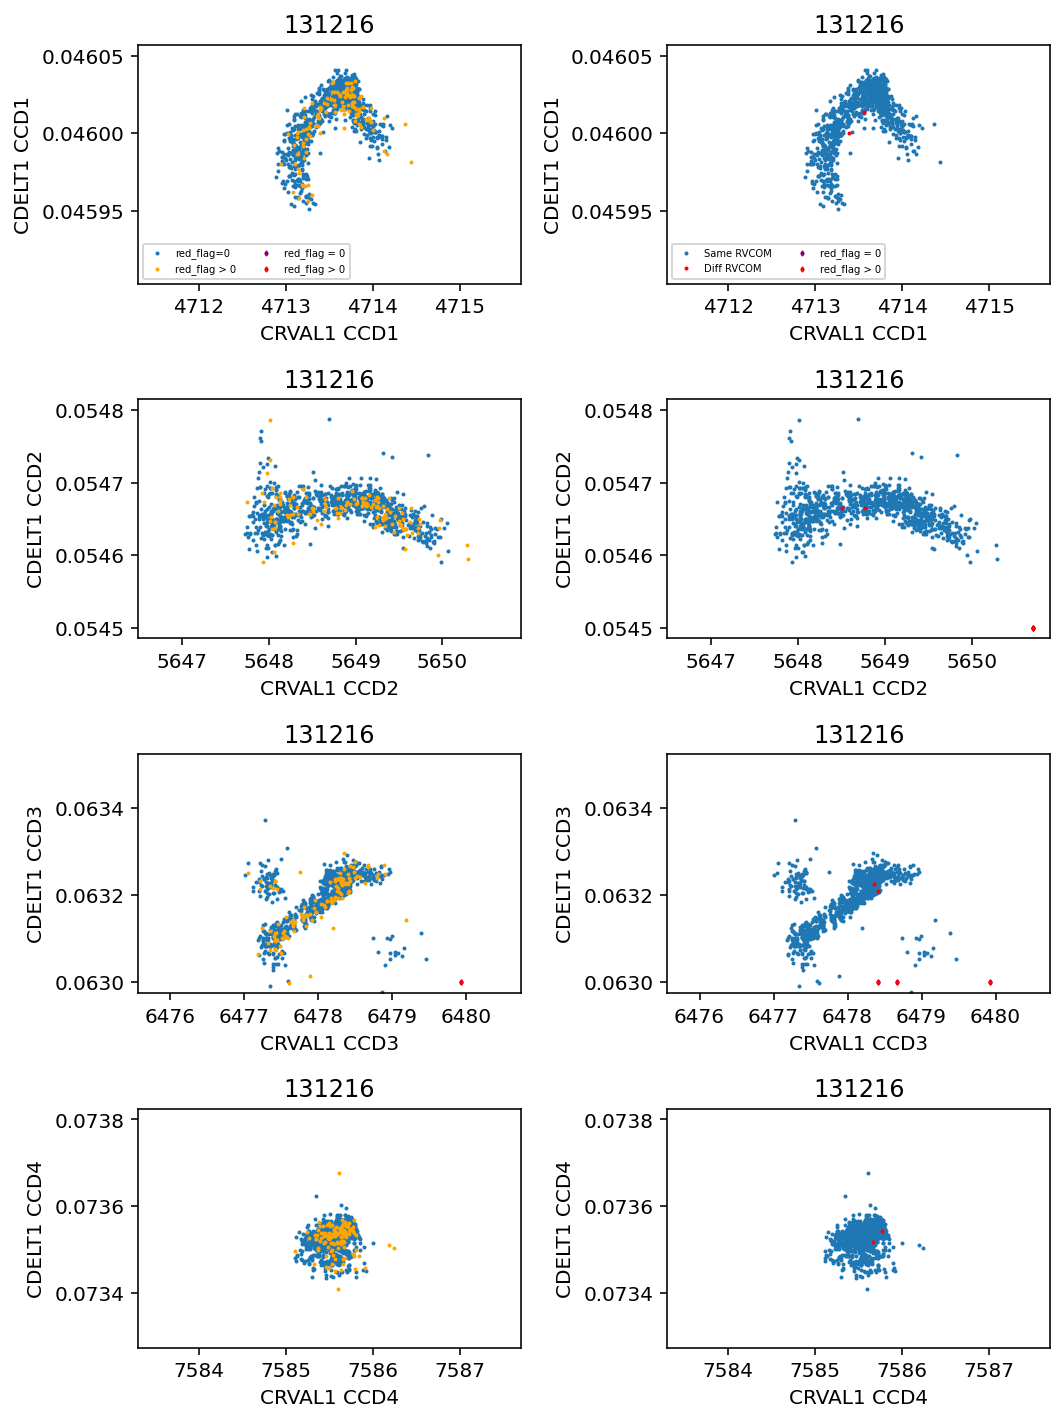

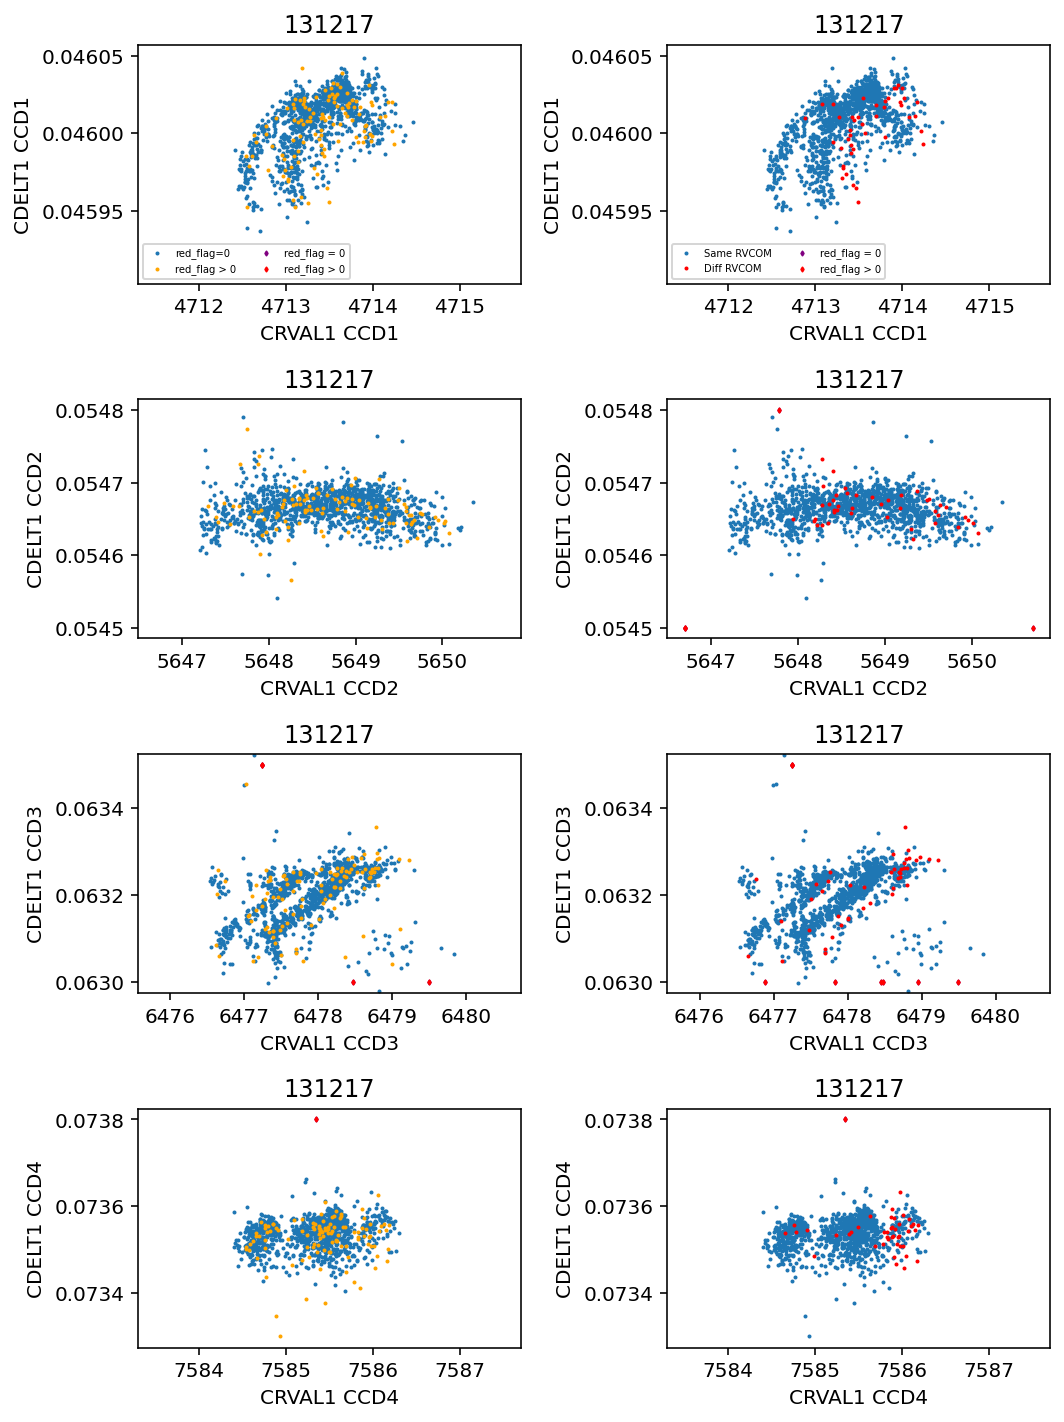

In [122]:
for date in np.unique(extra_info['date'])[:2]:
    
    f, gs = plt.subplots(4,2,figsize=(7.5,10))
    
    observations_of_that_night = date == extra_info['date']
    
    for ccd in [1,2,3,4]:

        ax = gs[ccd-1,0]
        ax.set_title(date)
        
        observations_of_that_night_without_reduction_flag = observations_of_that_night & (dr60['reduction_flags'] == 0)
        observations_of_that_night_with_reduction_flag = observations_of_that_night & (dr60['reduction_flags'] != 0)

        ax.scatter(
            extra_info['CRVAL1_ccd'+str(ccd)][observations_of_that_night_without_reduction_flag],
            extra_info['CDELT1_ccd'+str(ccd)][observations_of_that_night_without_reduction_flag],
            c = 'C0',
            s=1,
            label = 'red_flag=0'
        )
        ax.scatter(
            extra_info['CRVAL1_ccd'+str(ccd)][observations_of_that_night_with_reduction_flag],
            extra_info['CDELT1_ccd'+str(ccd)][observations_of_that_night_with_reduction_flag],
            c = 'orange',
            s=1,
            label = 'red_flag > 0'
        )
        
        ax.set_xlim(1.05 * ranges['CRVAL1_ccd'+str(ccd)+'_p1'] - 0.05 * ranges['CRVAL1_ccd'+str(ccd)+'_p99'], 1.05 * ranges['CRVAL1_ccd'+str(ccd)+'_p99'] -0.05 * ranges['CRVAL1_ccd'+str(ccd)+'_p1'])
        ax.set_ylim(1.05 * ranges['CDELT1_ccd'+str(ccd)+'_p1'] - 0.05 * ranges['CDELT1_ccd'+str(ccd)+'_p99'], 1.05 * ranges['CDELT1_ccd'+str(ccd)+'_p99'] -0.05 * ranges['CDELT1_ccd'+str(ccd)+'_p1'])

        left_outside = extra_info['CRVAL1_ccd'+str(ccd)] < 1.05 * ranges['CRVAL1_ccd'+str(ccd)+'_p1'] - 0.05 * ranges['CRVAL1_ccd'+str(ccd)+'_p99']
        right_outside = extra_info['CRVAL1_ccd'+str(ccd)] > 1.05 * ranges['CRVAL1_ccd'+str(ccd)+'_p99'] -0.05 * ranges['CRVAL1_ccd'+str(ccd)+'_p1']
        top_outside = extra_info['CDELT1_ccd'+str(ccd)] < 1.05 * ranges['CDELT1_ccd'+str(ccd)+'_p1'] - 0.05 * ranges['CDELT1_ccd'+str(ccd)+'_p99']
        bottom_outside = extra_info['CDELT1_ccd'+str(ccd)] > 1.05 * ranges['CDELT1_ccd'+str(ccd)+'_p99'] -0.05 * ranges['CDELT1_ccd'+str(ccd)+'_p1']
        
        outside_no_flag = observations_of_that_night_without_reduction_flag & (left_outside | right_outside | top_outside | bottom_outside)
        ax.scatter(
            extra_info['CRVAL1_ccd'+str(ccd)][outside_no_flag].clip(min=ranges['CRVAL1_ccd'+str(ccd)+'_p1'],max=ranges['CRVAL1_ccd'+str(ccd)+'_p99']),
            extra_info['CDELT1_ccd'+str(ccd)][outside_no_flag].clip(min=ranges['CDELT1_ccd'+str(ccd)+'_p1'],max=ranges['CDELT1_ccd'+str(ccd)+'_p99']),
            c = 'purple',
            marker = 'd',
            s = 2,
            label = 'red_flag = 0'
        )
        outside_flag = observations_of_that_night_with_reduction_flag & (left_outside | right_outside | top_outside | bottom_outside)
        ax.scatter(
            extra_info['CRVAL1_ccd'+str(ccd)][outside_no_flag].clip(min=ranges['CRVAL1_ccd'+str(ccd)+'_p1'],max=ranges['CRVAL1_ccd'+str(ccd)+'_p99']),
            extra_info['CDELT1_ccd'+str(ccd)][outside_no_flag].clip(min=ranges['CDELT1_ccd'+str(ccd)+'_p1'],max=ranges['CDELT1_ccd'+str(ccd)+'_p99']),
            c = 'r',
            marker = 'd',
            s = 2,
            label = 'red_flag > 0'
        )

        ax.set_xlabel('CRVAL1 CCD'+str(ccd))
        ax.set_ylabel('CDELT1 CCD'+str(ccd))

        if ccd == 1:
            ax.legend(ncol=2,fontsize=5)
            
        # Now Radial velocities
        ax = gs[ccd-1,1]
        ax.set_title(date)
        
        observations_of_that_night_with_same_rv = observations_of_that_night & extra_info['RVCOM_d3_ccd_same']
        observations_of_that_night_with_diff_rv = observations_of_that_night & (~extra_info['RVCOM_d3_ccd_same'])

        ax.scatter(
            extra_info['CRVAL1_ccd'+str(ccd)][observations_of_that_night_with_same_rv],
            extra_info['CDELT1_ccd'+str(ccd)][observations_of_that_night_with_same_rv],
            c = 'C0',
            s = 1,
            label = 'Same RVCOM'
        )
        ax.scatter(
            extra_info['CRVAL1_ccd'+str(ccd)][observations_of_that_night_with_diff_rv],
            extra_info['CDELT1_ccd'+str(ccd)][observations_of_that_night_with_diff_rv],
            c = 'r',
            s = 1,
            label = 'Diff RVCOM'
        )
        
        outside_no_flag = observations_of_that_night_with_same_rv & (left_outside | right_outside | top_outside | bottom_outside)
        ax.scatter(
            extra_info['CRVAL1_ccd'+str(ccd)][outside_no_flag].clip(min=ranges['CRVAL1_ccd'+str(ccd)+'_p1'],max=ranges['CRVAL1_ccd'+str(ccd)+'_p99']),
            extra_info['CDELT1_ccd'+str(ccd)][outside_no_flag].clip(min=ranges['CDELT1_ccd'+str(ccd)+'_p1'],max=ranges['CDELT1_ccd'+str(ccd)+'_p99']),
            c = 'purple',
            marker = 'd',
            s = 2,
            label = 'red_flag = 0'
        )
        outside_flag = observations_of_that_night_with_diff_rv & (left_outside | right_outside | top_outside | bottom_outside)
        ax.scatter(
            extra_info['CRVAL1_ccd'+str(ccd)][outside_no_flag].clip(min=ranges['CRVAL1_ccd'+str(ccd)+'_p1'],max=ranges['CRVAL1_ccd'+str(ccd)+'_p99']),
            extra_info['CDELT1_ccd'+str(ccd)][outside_no_flag].clip(min=ranges['CDELT1_ccd'+str(ccd)+'_p1'],max=ranges['CDELT1_ccd'+str(ccd)+'_p99']),
            c = 'r',
            marker = 'd',
            s = 2,
            label = 'red_flag > 0'
        )
        
        ax.set_xlim(1.05 * ranges['CRVAL1_ccd'+str(ccd)+'_p1'] - 0.05 * ranges['CRVAL1_ccd'+str(ccd)+'_p99'], 1.05 * ranges['CRVAL1_ccd'+str(ccd)+'_p99'] -0.05 * ranges['CRVAL1_ccd'+str(ccd)+'_p1'])
        ax.set_ylim(1.05 * ranges['CDELT1_ccd'+str(ccd)+'_p1'] - 0.05 * ranges['CDELT1_ccd'+str(ccd)+'_p99'], 1.05 * ranges['CDELT1_ccd'+str(ccd)+'_p99'] -0.05 * ranges['CDELT1_ccd'+str(ccd)+'_p1'])
        ax.set_xlabel('CRVAL1 CCD'+str(ccd))
        ax.set_ylabel('CDELT1 CCD'+str(ccd))

        if ccd == 1:
            ax.legend(ncol=2,fontsize=5)

    plt.tight_layout()
    plt.savefig('wavelength_solution/galah_dr4_cdelt1_crval1_'+str(date)+'.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
bad_cdelt1_ccd2 = extra_info['CDELT1_ccd2'] < 0.0542
# This always seems to be CCD2!

In [ ]:
extra_info[(
    (dr60['pivot'] == 282) &
    np.isfinite(extra_info['RVCOM_d3_ccd2'])
)]